In [1]:
# 1. DATA PREPARATION 
import numpy as np
import pandas as pd

### Read in data
bes_data = pd.read_csv("bes_data.csv")

In [2]:
### Have a look at first few observations
bes_data.head()

,Unnamed: 0,euVote,tooManyImmigrants,ability,partyIdentity,unionMember,income,livingSituation,gender,religion,age,ethnicGroup,education,workStatus,maritalStatus,region,wt_vote,euVote2
0,1,leave,0,-0.307871,Labour,No,3,2,2,0,1,White,0,4,3,East Midlands,1.110753,leave
1,2,remain,1,-0.307871,Labour,No,2,3,1,1,4,Asian,2,0,3,East Midlands,0.561521,remain
2,4,leave,1,-0.329742,Labour,No,9,1,2,1,6,White,0,1,1,East Midlands,0.919755,leave
3,5,remain,0,0.832879,Labour,No,10,1,2,1,6,White,7,1,1,East Midlands,0.651745,remain
4,9,remain,1,0.047353,Conservatives,No,4,1,1,1,6,White,0,4,1,East Midlands,1.724458,remain


In [3]:
### Recode factor variables
from sklearn.preprocessing import LabelEncoder
number = LabelEncoder()

bes_data['euVote'] = number.fit_transform(bes_data['euVote'].astype('str'))
bes_data['partyIdentity'] = number.fit_transform(bes_data['partyIdentity'].astype('str'))
bes_data['unionMember'] = number.fit_transform(bes_data['unionMember'].astype('str'))
bes_data['ethnicGroup'] = number.fit_transform(bes_data['ethnicGroup'].astype('str'))
bes_data['region'] = number.fit_transform(bes_data['region'].astype('str'))

### Have a look at first few observations
bes_data.head()

### For variable keys, see the README.MD of the repository.

,Unnamed: 0,euVote,tooManyImmigrants,ability,partyIdentity,unionMember,income,livingSituation,gender,religion,age,ethnicGroup,education,workStatus,maritalStatus,region,wt_vote,euVote2
0,1,0,0,-0.307871,2,0,3,2,2,0,1,4,0,4,3,0,1.110753,leave
1,2,2,1,-0.307871,2,0,2,3,1,1,4,0,2,0,3,0,0.561521,remain
2,4,0,1,-0.329742,2,0,9,1,2,1,6,4,0,1,1,0,0.919755,leave
3,5,2,0,0.832879,2,0,10,1,2,1,6,4,7,1,1,0,0.651745,remain
4,9,2,1,0.047353,0,0,4,1,1,1,6,4,0,4,1,0,1.724458,remain


In [4]:
### Prepare Xs and y for three regression models
X_demographic = bes_data[['ability','unionMember','income','livingSituation','gender','religion','age','ethnicGroup','education','workStatus','maritalStatus','region']]
X_euVote = bes_data[['euVote','ability','unionMember','income','livingSituation','gender','religion','age','ethnicGroup','education','workStatus','maritalStatus','region']]
X_immAttitude = bes_data[['euVote','tooManyImmigrants','ability','unionMember','income','livingSituation','gender','religion','age','ethnicGroup','education','workStatus','maritalStatus','region']]

y = bes_data['partyIdentity']

In [5]:
X_demographic.head()

,ability,unionMember,income,livingSituation,gender,religion,age,ethnicGroup,education,workStatus,maritalStatus,region
0,-0.307871,0,3,2,2,0,1,4,0,4,3,0
1,-0.307871,0,2,3,1,1,4,0,2,0,3,0
2,-0.329742,0,9,1,2,1,6,4,0,1,1,0
3,0.832879,0,10,1,2,1,6,4,7,1,1,0
4,0.047353,0,4,1,1,1,6,4,0,4,1,0


In [6]:
y.head()

0    2
1    2
2    2
3    2
4    0
Name: partyIdentity, dtype: int64

In [7]:
# 2. THREE MULTINOMIAL LOGISTIC REGRESSION (SOFTMAX) MODELS

from sklearn.linear_model import LogisticRegression

softmax_reg_demographic = LogisticRegression(multi_class="multinomial", solver="lbfgs", C=10, max_iter=10000, random_state=42)
softmax_reg_demographic.fit(X_demographic, y)

softmax_reg_euVote = LogisticRegression(multi_class="multinomial", solver="lbfgs", C=10, max_iter=10000, random_state=42)
softmax_reg_euVote.fit(X_euVote, y)

softmax_reg_immAttitude = LogisticRegression(multi_class="multinomial", solver="lbfgs", C=10, max_iter=10000, random_state=42)
softmax_reg_immAttitude.fit(X_immAttitude, y)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [8]:
### For illustration, predict category on first observation using demographic model
softmax_reg_demographic.predict([X_demographic.iloc[0,:]])

array([2])

In [9]:
### For illustration, predict probabilites on first observation
actual_prob = softmax_reg_demographic.predict_proba([X_demographic.iloc[0,:]])
actual_prob

array([[1.09073107e-01, 3.42111112e-02, 5.07382127e-01, 3.17070464e-02,
        2.37412304e-01, 1.83673769e-04, 6.18804542e-02, 1.81501764e-02]])

In [10]:
# 3. MODEL EVALUATION

from sklearn.metrics import log_loss

y_pred_demo = softmax_reg_demographic.predict_proba(X_demographic)
logloss_demo = log_loss(y, y_pred_demo)

y_pred_eu = softmax_reg_euVote.predict_proba(X_euVote)
logloss_eu = log_loss(y, y_pred_eu)

y_pred_imm = softmax_reg_immAttitude.predict_proba(X_immAttitude)
logloss_imm = log_loss(y, y_pred_imm)

In [11]:
def display_loglosses(dem,eu,imm):
    print("Demographic model:", logloss_demo)
    print("EU Vote model:", logloss_eu)
    print("Immigration Attitude model:", logloss_imm)

display_loglosses(logloss_demo, logloss_eu, logloss_imm)

Demographic model: 1.3101665681790216
EU Vote model: 1.2641535106482693
Immigration Attitude model: 1.2427465811819718


In [12]:
### For context, a dumb log loss on 8 classes is -log(1/8) = 2.079442, given balanced classes
### Calculate a dumb log loss for unbalanced case that simply uses base rates

all_votes = bes_data['partyIdentity'].value_counts().sum()

cons = bes_data['partyIdentity'].value_counts()[0]/all_votes
greens = bes_data['partyIdentity'].value_counts()[1]/all_votes
lab = bes_data['partyIdentity'].value_counts()[2]/all_votes
libdem = bes_data['partyIdentity'].value_counts()[3]/all_votes
novote = bes_data['partyIdentity'].value_counts()[4]/all_votes
plaid = bes_data['partyIdentity'].value_counts()[5]/all_votes
snp = bes_data['partyIdentity'].value_counts()[6]/all_votes
ukip = bes_data['partyIdentity'].value_counts()[7]/all_votes

y_array_br = np.array([cons,greens,lab,libdem,novote,plaid,snp,ukip])
y_array_tiled_br = np.tile(y_array_br,(1425,1))
logloss_dumb_br = log_loss(y, y_array_tiled_br)
logloss_dumb_br

1.4710788456126085

In [13]:
# 4. SIMULATION OF FULLY INFORMED (REPORTED) PREFERENCES

### Find maximum ability value
maxValue = X_demographic['ability'].max()
maxValue

0.8328792750513141

In [14]:
### Take first observation from data as example
obs = X_demographic.iloc[0,:].copy()

### Assign max ability value to that observation
obs[0] = maxValue
obs

ability            0.832879
unionMember        0.000000
income             3.000000
livingSituation    2.000000
gender             2.000000
religion           0.000000
age                1.000000
ethnicGroup        4.000000
education          0.000000
workStatus         4.000000
maritalStatus      3.000000
region             0.000000
Name: 0, dtype: float64

In [15]:
### Predict informed vote using demographic model
softmax_reg_demographic.predict([obs])

array([2])

In [16]:
### Predict full probability distribution over all parties (and abstain) using same model
full_inf_prob = softmax_reg_demographic.predict_proba([obs])
full_inf_prob

array([[1.24311579e-01, 6.90485053e-02, 4.64686928e-01, 5.99198683e-02,
        1.86775405e-01, 2.89189175e-04, 8.62093782e-02, 8.75914744e-03]])

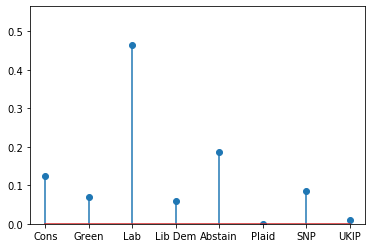

In [21]:
### Plot the distribution
import matplotlib.pyplot as plt

x=["Cons","Green","Lab","Lib Dem","Abstain","Plaid","SNP","UKIP"]
values=full_inf_prob.tolist()[0]

plt.stem(x, values, use_line_collection=True)
plt.ylim(0, max(values) + 0.1)
plt.show()

In [22]:
# 5. DIFFERENCE BETWEEN ACTUAL AND FULLY INFORMED VOTE

### Calculate difference between the person's actual vote and their fully informed distribution
actual_vote = [0,0,0,0,0,0,0,0]
actual_vote[y[0]] = 1
prob_diff = np.subtract(full_inf_prob, actual_vote)
prob_diff

array([[ 1.24311579e-01,  6.90485053e-02, -5.35313072e-01,
         5.99198683e-02,  1.86775405e-01,  2.89189175e-04,
         8.62093782e-02,  8.75914744e-03]])

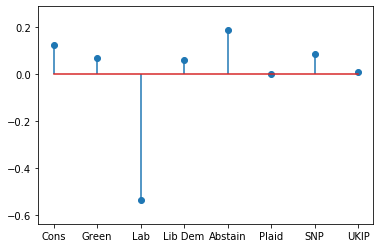

In [23]:
### Plot that difference
x=["Cons","Green","Lab","Lib Dem","Abstain","Plaid","SNP","UKIP"]
values=prob_diff.tolist()[0]

plt.stem(x, values, use_line_collection=True)
plt.ylim(min(prob_diff.tolist()[0]) - 0.1, max(prob_diff.tolist()[0]) + 0.1)
plt.show()
%matplotlib notebook

In [24]:
# 6. AGGREGATE DIFFERENCE BETWEEN ACTUAL AND FULLY INFORMED VOTES

### Calculate actual proportions of support
all_votes = bes_data['partyIdentity'].value_counts().sum()

cons = bes_data['partyIdentity'].value_counts()[0]/all_votes
greens = bes_data['partyIdentity'].value_counts()[1]/all_votes
lab = bes_data['partyIdentity'].value_counts()[2]/all_votes
libdem = bes_data['partyIdentity'].value_counts()[3]/all_votes
novote = bes_data['partyIdentity'].value_counts()[4]/all_votes
plaid = bes_data['partyIdentity'].value_counts()[5]/all_votes
snp = bes_data['partyIdentity'].value_counts()[6]/all_votes
ukip = bes_data['partyIdentity'].value_counts()[7]/all_votes

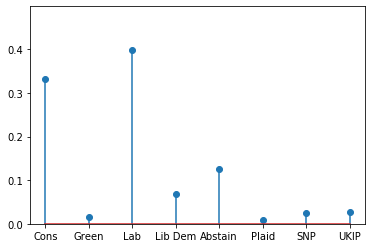

In [26]:
### Plot proportions of actual support
x=["Cons","Green","Lab","Lib Dem","Abstain","Plaid","SNP","UKIP"]
values_actual=[cons,greens,lab,libdem,novote,plaid,snp,ukip]
 
plt.stem(x, values_actual, use_line_collection=True)
plt.ylim(0, max(values_actual) + 0.1)
plt.show()
%matplotlib notebook

In [27]:
### Copy X and assign max ability value to all observations
all_obs = X_demographic.copy()
all_obs['ability'] = maxValue
all_obs.head()

,ability,unionMember,income,livingSituation,gender,religion,age,ethnicGroup,education,workStatus,maritalStatus,region
0,0.832879,0,3,2,2,0,1,4,0,4,3,0
1,0.832879,0,2,3,1,1,4,0,2,0,3,0
2,0.832879,0,9,1,2,1,6,4,0,1,1,0
3,0.832879,0,10,1,2,1,6,4,7,1,1,0
4,0.832879,0,4,1,1,1,6,4,0,4,1,0


In [28]:
### Calculate fully informed distribution for each observation
all_obs_full_inf = softmax_reg_demographic.predict_proba(all_obs)
all_obs_full_inf

array([[1.24311579e-01, 6.90485053e-02, 4.64686928e-01, ...,
        2.89189175e-04, 8.62093782e-02, 8.75914744e-03],
       [8.60233809e-02, 1.36300538e-03, 7.69747143e-01, ...,
        6.85116245e-06, 1.03803656e-04, 8.34675389e-04],
       [7.16399507e-01, 1.39987876e-03, 1.90261723e-01, ...,
        1.26881432e-03, 2.14045470e-02, 6.11626737e-03],
       ...,
       [4.48587312e-01, 2.56372066e-02, 2.26606804e-01, ...,
        1.79627015e-02, 3.03983640e-02, 9.12482989e-03],
       [4.77377320e-01, 7.85206441e-03, 2.82438474e-01, ...,
        6.36204438e-03, 4.70406254e-02, 2.51355898e-02],
       [5.91101390e-01, 7.17358644e-03, 1.68878399e-01, ...,
        2.77352207e-03, 8.94926093e-03, 1.20648386e-02]])

In [29]:
### Calculate the mean probability for each party (or abstain)
mean_full_inf = all_obs_full_inf.mean(axis = 0)

<IPython.core.display.Javascript object>


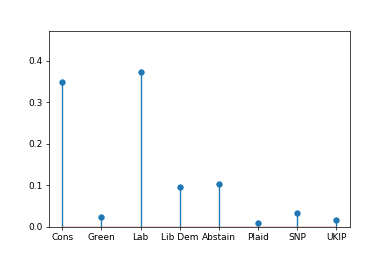

In [30]:
### Plot proportions of simulated fully informed support
x=["Cons","Green","Lab","Lib Dem","Abstain","Plaid","SNP","UKIP"]
values_sim=[mean_full_inf[0],mean_full_inf[1],mean_full_inf[2],mean_full_inf[3],mean_full_inf[4],mean_full_inf[5],mean_full_inf[6],mean_full_inf[7]]
 
plt.stem(x, values_sim, use_line_collection=True)
plt.ylim(0, max(values_sim) + 0.1)
plt.show()

<IPython.core.display.Javascript object>


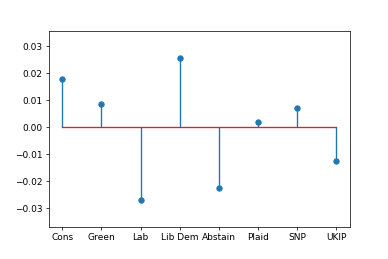

In [32]:
### Plot aggregate information effect, i.e., difference between actual and simulated support
x=["Cons","Green","Lab","Lib Dem","Abstain","Plaid","SNP","UKIP"]
support_diff = np.subtract(values_sim, values_actual)

plt.stem(x, support_diff, use_line_collection=True)
plt.ylim(min(support_diff) - 0.01, max(support_diff) + 0.01)
plt.show()